### Importing libraries

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import linear_model
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

# Question 1: Propensity score matching

## Loading the data

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

The dataset contains 614 observations.
We observe that the categorical variables are encoded using dummy varibales, i.e. binary variables. We are going to stick with this encoding as it is advantegous for the regression task that we are going to perform later. 



In [2]:
lalonde_data = pd.read_csv("lalonde.csv")
lalonde_data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [3]:
len(lalonde_data)

614

## 1. A naive analysis

To begin with, we compare the distribution of the outcome variable (re78) between the two groups in a naive way. This means that we do not consider relationships between the outcome variable and other available features, and just focus on the differences (possibly) induced by participating in the job training program.

We compare the distributions based on:

1. Boxplot diagrams
2. Histograms
3. QQ plots
4. Summary statistics
5. Mann-Whitney-U test (sometimes also referred to as Wilcoxon signed rank test.)

For these steps of the analysis we define the following functions:

In [4]:
treat = {0: 'treated', 1: 'control'}

def draw_box(df, col):
    """Draw a box plot for the values of the specified column for each of the two groups"""
    df.boxplot(by='treat', column=col, figsize = [5, 5], grid=False)
    plt.show()

def draw_hist(df, col):
    """Draw histograms and kernel density estimation plots for the specified column.
    Two plots are created for the two groups but displayed in two overlapping layers for comparison.
    """
    fig_hist, axs_hist = plt.subplots(nrows=2, sharex=True)
    df.groupby("treat")[col].plot(kind='kde', ax=axs_hist[1])
    axs_hist[1].set_xlabel(col)
    axs_hist[1].set_xlim(xmin=0)
    groups = df.groupby("treat")[col]
    for k, v in groups:
        v.hist(label=treat[k], alpha=.75, ax=axs_hist[0], bins=15, range=[df[col].min(), df[col].max()], figsize = [8, 5])
    axs_hist[0].legend()
    axs_hist[0].set_ylabel('number of participants')
    plt.show()

def draw_qqs(df, col):
    """Draw a QQ plot for both groups to find out more about the distribution of the data.
    NB: A comparison to a normal distribution with fitted parameters is performed."""
    fig_qq, axs_qq = plt.subplots(ncols=2, figsize=(8, 4), sharex=True, sharey=True)
    stats.probplot(df[df.treat == 0][col], dist="norm", plot=axs_qq[0])
    axs_qq[0].set_title('Control Group')
    axs_qq[0].set_xlim(xmin=0)
    stats.probplot(df[df.treat == 1][col], dist="norm", plot=axs_qq[1])
    axs_qq[1].set_title('Treatment Group')
    plt.show()
    
def get_summary(df, col):
    """Print summary statistics for both groups."""
    print('Control group')
    print('================================================')
    print(round(df[df.treat == 0][col].describe(), 2))
    print('================================================')
    print()
    print('Treatment group')
    print('================================================')
    print(round(df[df.treat == 1][col].describe(), 2))

def test(df, col):
    """Perform Mann-Whitney-U test and pretty print result.""" 
    s, p = stats.mannwhitneyu(df[df.treat == 0][col], df[df.treat == 1][col])
    print('Mann-Whitney-U test:')
    print('================================================')
    print('p-value: ', round(p, 4))
    print('test statistic: ', round(s, 1))

Furthermore, we define a function that invokes all the functions for numerical features and displays the output in a structured way.

In [5]:
def analyse_numeric(df, col, detailed=True):    
    """Perform analysis for a numerical feature and pretty print result."""
    print('=================================================================================')
    print('                                  ', col)
    print('=================================================================================')
    draw_box(df, col)
    draw_hist(df, col)
    if(detailed):
        draw_qqs(df, col)
    print()
    get_summary(df, col)
    print()
    test(df, col)
    print()
    print()

Let us now analyse the distribution of the real earnings in 1978 within the two groups. The boxplot diagram shows that the median earning differs only slightly between the groups, and also the distributions are similar considering the interquartile range which is a measure of dispersion. However, we observe that there are some outliers in the treatment group that exhibit high earnings. The tables below give a numerical summary of the distribution of earnings within the groups. Interestingly, the upper quartile earning is higher in the control than in the treatment group.
The similarity between the two distributions is even more clearly visible from the kernel density estimates (or the histograms). To determine whether the observed (minor) differences are of significance, statistical test shall be computed. With numeric features, the t-test is a common means to test differences between the mean value of two groups. One necessary condition to use the t-test is that the features follow a normal distribution. To determine this, Quantile-Quantile Plots are drawn which show clear deviations from normality (normality would be fulfilled if the blue points would be evenly grouped around the diagonal). In the absence of normality, the Wilcoxon signed rank test is a nonparametric alternative. Here, we compare group medians instead of means. Regarding the earnings in 1978, the Wilcoxon test shows no significant difference between the medians of the two groups at a test level of 0.05 (p-value = 0.1409). This is in accordance with our observations from the boxplot diagram or histogram/density estimates.

                                   re78


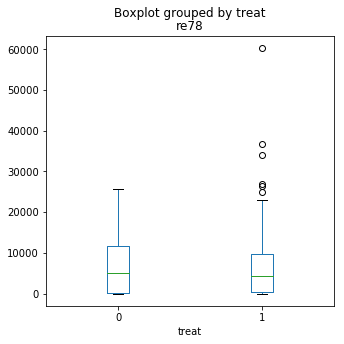

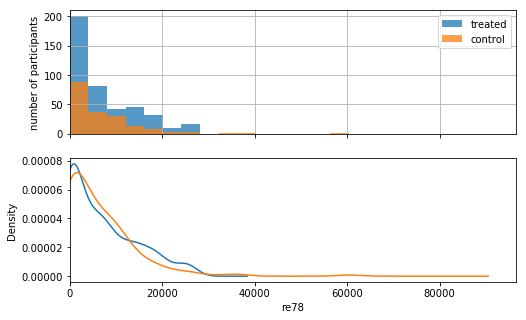

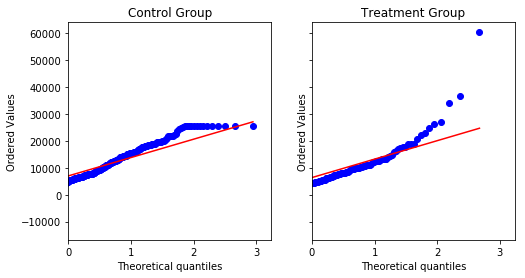


Control group
count      429.00
mean      6984.17
std       7294.16
min          0.00
25%        220.18
50%       4975.50
75%      11688.82
max      25564.67
Name: re78, dtype: float64

Treatment group
count      185.00
mean      6349.14
std       7867.40
min          0.00
25%        485.23
50%       4232.31
75%       9643.00
max      60307.93
Name: re78, dtype: float64

Mann-Whitney-U test:
p-value:  0.1409
test statistic:  37525.0




In [6]:
analyse_numeric(lalonde_data, 're78')

## 2. A closer look at the data

In order to get a better understanding of whether our naive analysis was appropriate, we now compare the distributions of the other covariates within the treatment groups. This is necessary as the observed sample was not randomly drawn. If differences are observed, these could influence the outcome of the above analysis as one would assume, for example, older people to have higher income in general. The effect of the treatment might then be confounded with that of the age effect. 


### Analysis of quantitative features

To analyse possible imbalance, we analyse the numerical features using the same strategy as in Part 1.

Considering the age distribution between treatment and control group, differences are apparent. People in the treatment group tend to be younger than in the control group, although the median age is not significantly different (Wilcoxon rank sum test, p-value = 0.2598).


                                   age


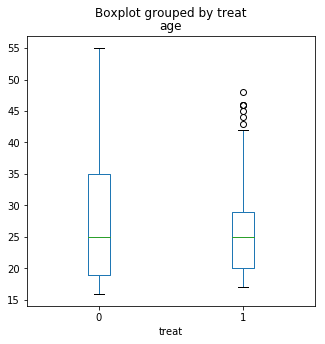

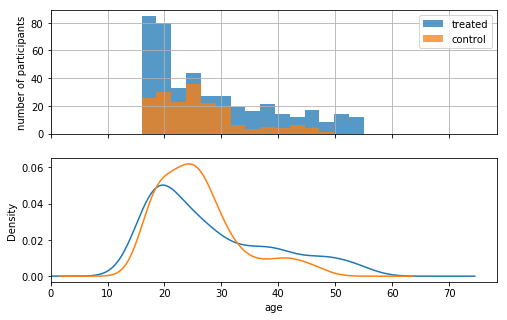

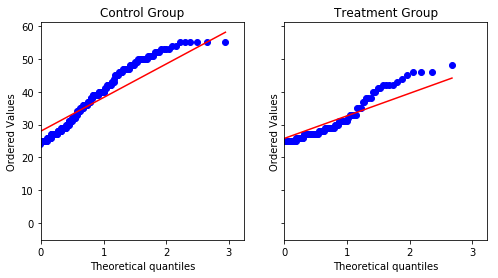


Control group
count    429.00
mean      28.03
std       10.79
min       16.00
25%       19.00
50%       25.00
75%       35.00
max       55.00
Name: age, dtype: float64

Treatment group
count    185.00
mean      25.82
std        7.16
min       17.00
25%       20.00
50%       25.00
75%       29.00
max       48.00
Name: age, dtype: float64

Mann-Whitney-U test:
p-value:  0.2598
test statistic:  38384.5




In [7]:
analyse_numeric(lalonde_data, 'age')

Considering years of education, differences are far less apparent. True, the control group exhibits outliers in both directions, but the median number of education years as well as the interquartile range is similar in both groups. Wilcoxon rank sum test gives again no significant result (p-value = 0.396).

                                   educ


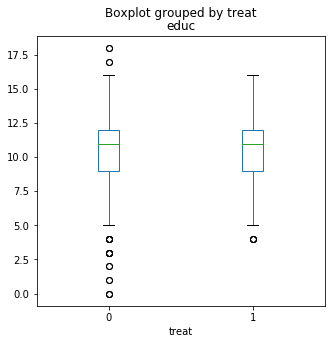

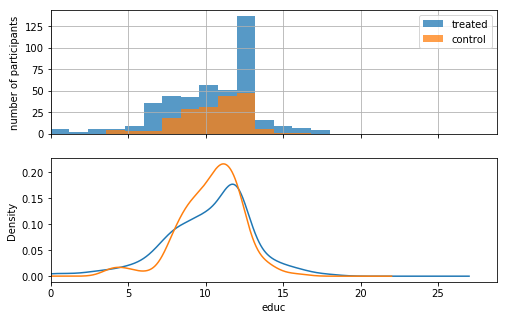

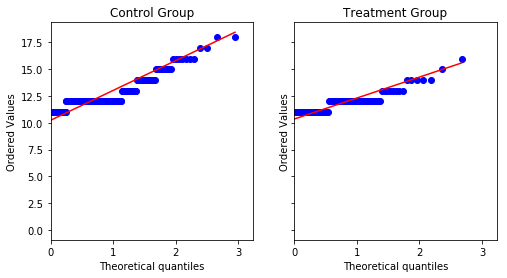


Control group
count    429.00
mean      10.24
std        2.86
min        0.00
25%        9.00
50%       11.00
75%       12.00
max       18.00
Name: educ, dtype: float64

Treatment group
count    185.00
mean      10.35
std        2.01
min        4.00
25%        9.00
50%       11.00
75%       12.00
max       16.00
Name: educ, dtype: float64

Mann-Whitney-U test:
p-value:  0.396
test statistic:  39157.0




In [8]:
analyse_numeric(lalonde_data, 'educ')

Now, the earnings in 1974 show significant differences between the two groups. The boxplot diagram (or consult the tables below) shows that the median earning in the treatment group is 0, and people earning more than about 4000 are considered outliers. This difference is supported by a significant test result (p-value < 0.001), indicating that the earnings in 1974 were indeed significantly different between the two groups. The kernel density estimation is again a different way of visualizing this difference, showing that the mean earning in the control group is indeed higher than the treatment's group.

                                   re74


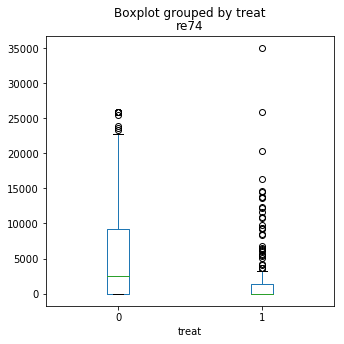

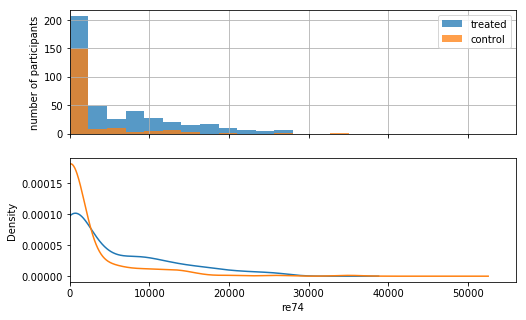

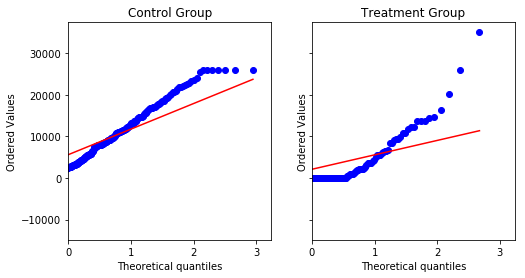


Control group
count      429.00
mean      5619.24
std       6788.75
min          0.00
25%          0.00
50%       2547.05
75%       9277.13
max      25862.32
Name: re74, dtype: float64

Treatment group
count      185.00
mean      2095.57
std       4886.62
min          0.00
25%          0.00
50%          0.00
75%       1291.47
max      35040.07
Name: re74, dtype: float64

Mann-Whitney-U test:
p-value:  0.0
test statistic:  21928.0




In [9]:
analyse_numeric(lalonde_data, 're74')

In concordance with the earnings in 1974, the same conclusions can be drawn for the earning in the consecutive year 1975. Here again, earnings are higher in the control than in the treatment group. These obvious differences lead us to conclude that there is a certain selection bias as to which persons are in the treatment group. This makes sense as people with less income or unemployed people might be more open to participating in a job training program. Again, Mann Whitney U Test gives a significant result (p-value < 0.001).

                                   re75


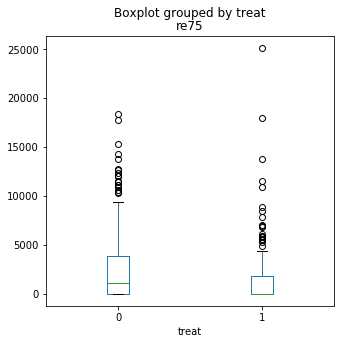

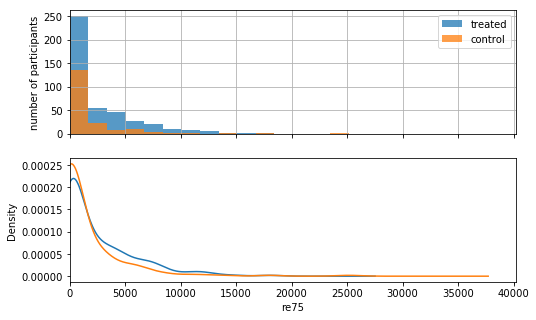

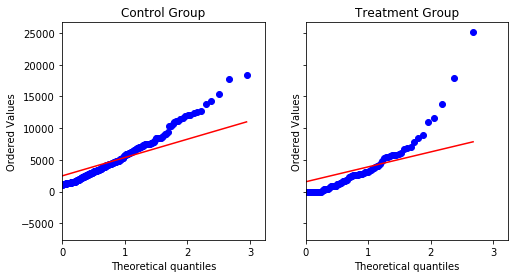


Control group
count      429.00
mean      2466.48
std       3292.00
min          0.00
25%          0.00
50%       1086.73
75%       3881.42
max      18347.23
Name: re75, dtype: float64

Treatment group
count      185.00
mean      1532.06
std       3219.25
min          0.00
25%          0.00
50%          0.00
75%       1817.28
max      25142.24
Name: re75, dtype: float64

Mann-Whitney-U test:
p-value:  0.0
test statistic:  28612.0




In [10]:
analyse_numeric(lalonde_data, 're75')

### Analysis of categorical features

It remains to take a closer look at the categorical covariates. As the methods used above are not appropriate for categorical variables, we need to define new functions for the analysis. For example, there is no point in drawing histograms for categrical variables, the thing to use here are bar plots. The chi-square test is used to analyse possible group differences.

In [11]:
def draw_bar(df, col):
    '''Draw a bar plot of the number of values in each category for the two groups'''
    df_grouped = df.groupby(['treat', col])[col].count()
    df_grouped = df_grouped.unstack()
    display(df_grouped)
    df_grouped = df_grouped.div(df_grouped.sum(axis=1), axis=0)
    pl = df_grouped.plot(kind='bar', figsize=[5,5], rot=0)
    pl.set_title(col)
    pl.set_ylabel('proportion of participants')
    pl.set_xlabel('treatment group')
    plt.show()

For the race feature some preprocessing is needed in order to be able to draw a meaningful bar plot. Especially, the data frame does not contain a column for white people. We assume that individuals are white in case they are neither black nor hispanic.

In [12]:
def plot_race(df):
    '''Draw a bar plot for the race feature.'''
    df['white'] = (~(df['black'].astype(bool) | df['hispan'].astype(bool))).astype(int)
    df_grouped = df.groupby(df.treat)['white', 'black', 'hispan'].sum()
    del df['white']
    display(df_grouped)
    df_grouped = df_grouped.div(df_grouped.sum(axis=1), axis=0)
    pl = df_grouped.plot(kind='bar', figsize=[7,5], rot=0)
    pl.set_title('race')
    pl.set_ylabel('proportion of participants')
    pl.set_xlabel('treatment group')
    plt.show()

In [13]:
def test_chisq(df, table):
    '''Perform chi square test'''
    print('Chi-square test')
    print('================================================')
    #perform test
    s, p, _, _ = stats.chi2_contingency(table)
    print('p-value: ', round(p, 4))
    print('test statistic: ', round(s, 1))

In [14]:
def analyse_categoric(df, col):    
    """Perform analysis for a categorical feature and pretty print result."""
    print('=================================================================================')
    print('                                  ', col)
    print('=================================================================================')
    draw_bar(df, col)
    print()
    
    #compute contingency table and perform test
    df['neg'] = df[col].apply(lambda x: 1-x)
    table = df.groupby(df.treat)[col, 'neg'].sum()
    del df['neg']
    test_chisq(df, table)
    
    print()
    print()

In [15]:
def analyse_race(df):    
    """Perform analysis for the race feature and pretty print result."""
    print('=================================================================================')
    print('                                  race')
    print('=================================================================================')
    plot_race(df)
    print()
    print()
    
    #compute contingency table and perform test
    df['white'] = (~(df['black'].astype(bool) | df['hispan'].astype(bool))).astype(int)
    table = df.groupby(df.treat)['white', 'black', 'hispan'].sum()
    del df['white']
    
    test_chisq(df, table)

In the treatment group we find relatively more married people than in the control group. This difference is significant, or to put it in other words: there is a significant dependence between the marital state and group membership (Chi-square test, p-value < 0.001). However, this may also be due to the fact that the treatment group holds more young people, which tend to be not (yet) married. Here again might be some kind of confounding.analysis:

                                   married


married,0,1
treat,,
0,209,220
1,150,35


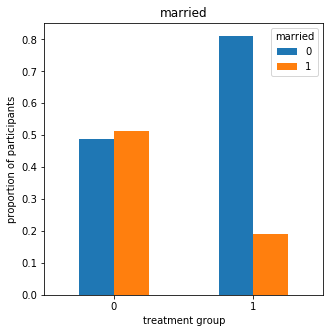


Chi-square test
p-value:  0.0
test statistic:  54.4




In [16]:
analyse_categoric(lalonde_data, 'married')

The same applies to *nodegree*, where we could find a significant relationship between group membership and *nodegree* (p-value = 0.0113).

                                   nodegree


nodegree,0,1
treat,,
0,173,256
1,54,131


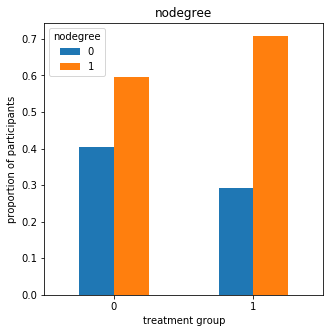


Chi-square test
p-value:  0.0113
test statistic:  6.4




In [17]:
analyse_categoric(lalonde_data, 'nodegree')

Finally, the participants race is included in the data as is often so with US studies. Interestingly, mostly black people participate in the treatment group. There are various studies analyzing the relationship between race and, for example, earnings. So here again, we find a possible source for confounding. The difference in earnings in the years 1974/5 might well be due to this difference in race structure between the two groups. However, no further analysis is conducted in this direction.

                                  race


,white,black,hispan
treat,,,
0,281,87,61
1,18,156,11


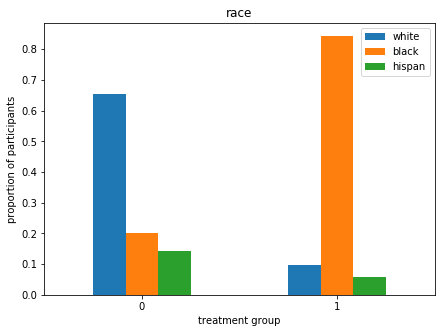



Chi-square test
p-value:  0.0
test statistic:  224.1


In [18]:
analyse_race(lalonde_data)

## 3. A propensity score model

In [19]:
logistic = linear_model.LogisticRegression()

logistic = logistic.fit(lalonde_data.drop(lalonde_data.columns[[0, 1, -1]], axis=1), lalonde_data.treat)
propensity_scores = logistic.predict_proba(lalonde_data.drop(lalonde_data.columns[[0, 1, -1]], axis=1))

In [20]:
print(logistic.classes_)
print(propensity_scores[:5])

[0 1]
[[ 0.55664958  0.44335042]
 [ 0.85534047  0.14465953]
 [ 0.27764537  0.72235463]
 [ 0.33584948  0.66415052]
 [ 0.30171439  0.69828561]]


In [21]:
lalonde_data['propensity'] = propensity_scores[:, 1]

## 4. Balancing the dataset via matching

1:1, without replacement
optimal matching

In [22]:
graph_data = pd.merge(lalonde_data.reset_index()[lalonde_data.treat == 1].assign(key=0), lalonde_data.reset_index()[lalonde_data.treat == 0].assign(key=0), on='key').drop('key', axis=1)
graph_data['weight'] = 1 - np.abs(graph_data['propensity_x'] - graph_data['propensity_y'])
G = nx.Graph()
G.add_weighted_edges_from(zip(graph_data.index_x, graph_data.index_y, graph_data.weight))
matching = nx.max_weight_matching(G)

In [23]:
len(matching) == 2 * len(lalonde_data[lalonde_data.treat == 1])

True

In [24]:
lalonde_data_balanced = lalonde_data.iloc[list(matching.keys())]
lalonde_data_balanced.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


## Perform same analysis as in 1 and 2 

                                   re78


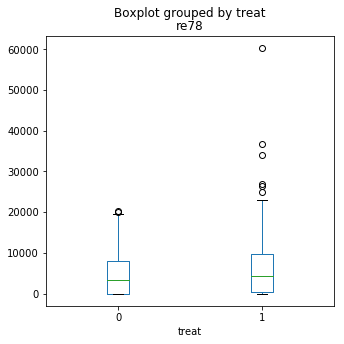

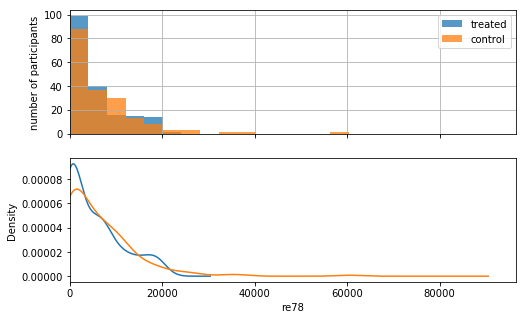


Control group
count      185.00
mean      5312.47
std       5842.88
min          0.00
25%          0.00
50%       3392.86
75%       7933.91
max      20243.38
Name: re78, dtype: float64

Treatment group
count      185.00
mean      6349.14
std       7867.40
min          0.00
25%        485.23
50%       4232.31
75%       9643.00
max      60307.93
Name: re78, dtype: float64

Mann-Whitney-U test:
p-value:  0.1754
test statistic:  16159.5




In [25]:
analyse_numeric(lalonde_data_balanced, 're78', detailed=False)

                                   age


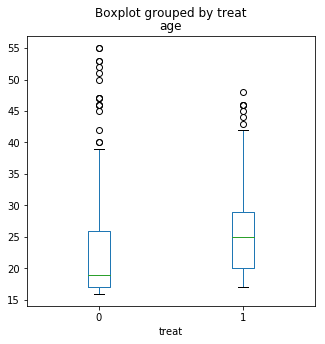

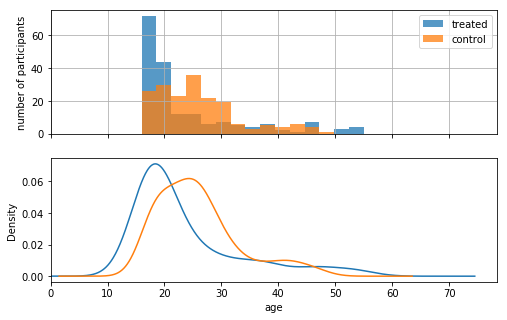


Control group
count    185.00
mean      23.71
std        9.64
min       16.00
25%       17.00
50%       19.00
75%       26.00
max       55.00
Name: age, dtype: float64

Treatment group
count    185.00
mean      25.82
std        7.16
min       17.00
25%       20.00
50%       25.00
75%       29.00
max       48.00
Name: age, dtype: float64

Mann-Whitney-U test:
p-value:  0.0
test statistic:  11661.5




In [26]:
analyse_numeric(lalonde_data_balanced, 'age', detailed=False)

                                   educ


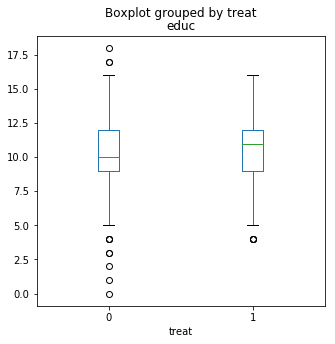

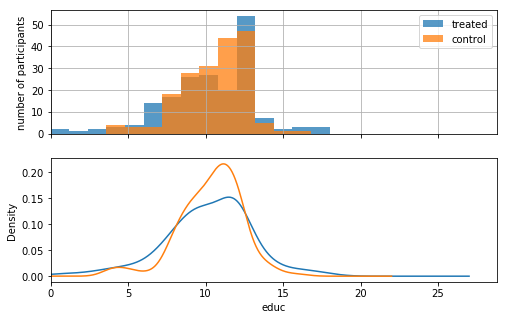


Control group
count    185.00
mean      10.16
std        2.86
min        0.00
25%        9.00
50%       10.00
75%       12.00
max       18.00
Name: educ, dtype: float64

Treatment group
count    185.00
mean      10.35
std        2.01
min        4.00
25%        9.00
50%       11.00
75%       12.00
max       16.00
Name: educ, dtype: float64

Mann-Whitney-U test:
p-value:  0.3611
test statistic:  16751.0




In [27]:
analyse_numeric(lalonde_data_balanced, 'educ', detailed=False)

                                   re74


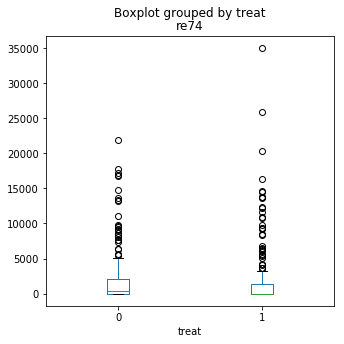

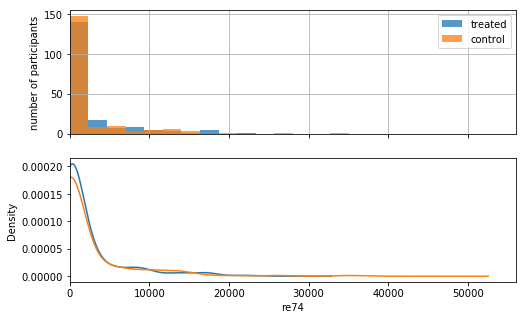


Control group
count      185.00
mean      2095.89
std       4029.20
min          0.00
25%          0.00
50%        289.97
75%       2068.99
max      21918.32
Name: re74, dtype: float64

Treatment group
count      185.00
mean      2095.57
std       4886.62
min          0.00
25%          0.00
50%          0.00
75%       1291.47
max      35040.07
Name: re74, dtype: float64

Mann-Whitney-U test:
p-value:  0.0002
test statistic:  13873.0




In [28]:
analyse_numeric(lalonde_data_balanced, 're74', detailed=False)

                                   re75


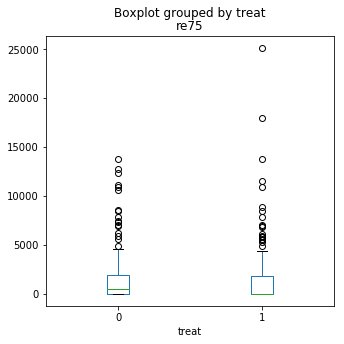

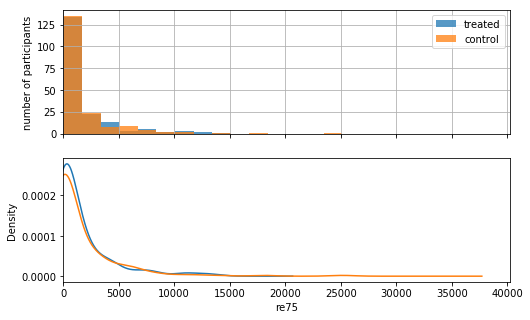


Control group
count      185.00
mean      1615.31
std       2674.75
min          0.00
25%          0.00
50%        451.16
75%       1890.58
max      13776.53
Name: re75, dtype: float64

Treatment group
count      185.00
mean      1532.06
std       3219.25
min          0.00
25%          0.00
50%          0.00
75%       1817.28
max      25142.24
Name: re75, dtype: float64

Mann-Whitney-U test:
p-value:  0.0034
test statistic:  14504.0




In [29]:
analyse_numeric(lalonde_data_balanced, 're75', detailed=False)

                                   married


married,0,1
treat,,
0,154,31
1,150,35


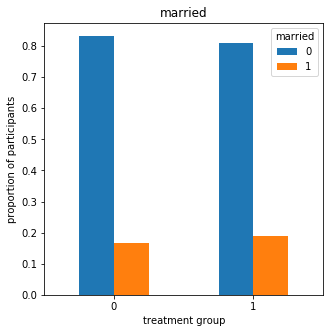


Chi-square test
p-value:  0.6837
test statistic:  0.2




In [30]:
analyse_categoric(lalonde_data_balanced, 'married')

                                   nodegree


nodegree,0,1
treat,,
0,69,116
1,54,131


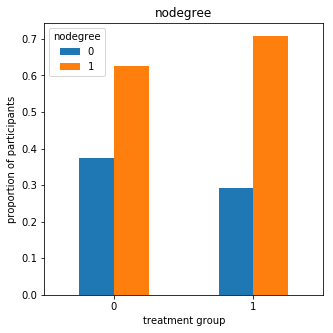


Chi-square test
p-value:  0.1223
test statistic:  2.4




In [31]:
analyse_categoric(lalonde_data_balanced, 'nodegree')

                                  race


,white,black,hispan
treat,,,
0,76,87,22
1,18,156,11


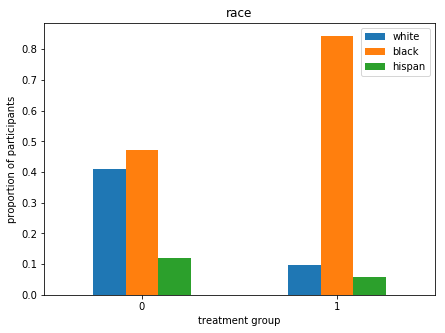



Chi-square test
p-value:  0.0
test statistic:  59.0


In [32]:
analyse_race(lalonde_data_balanced)

not satisfied: re75, re74, age, race(?)

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching? Would you say your dataset is sufficiently balanced? If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

## 5. Balancing the groups further

identify "the problematic feature": if different in this feature: add very high penalty to weight, oder: direkt in join auf equality filtern :P

problenatic features: age, race

Further balance for race:

In [33]:
graph_data = pd.merge(lalonde_data.reset_index()[lalonde_data.treat == 1], lalonde_data.reset_index()[lalonde_data.treat == 0], on=['black', 'hispan'])
print(graph_data)
graph_data['weight'] = 1 - np.abs(graph_data['propensity_x'] - graph_data['propensity_y'])
G = nx.Graph()
G.add_weighted_edges_from(zip(graph_data.index_x, graph_data.index_y, graph_data.weight))
matching = nx.max_weight_matching(G)

       index_x    id_x  treat_x  age_x  educ_x  black  hispan  married_x  \
0            0    NSW1        1     37      11      1       0          1   
1            0    NSW1        1     37      11      1       0          1   
2            0    NSW1        1     37      11      1       0          1   
3            0    NSW1        1     37      11      1       0          1   
4            0    NSW1        1     37      11      1       0          1   
5            0    NSW1        1     37      11      1       0          1   
6            0    NSW1        1     37      11      1       0          1   
7            0    NSW1        1     37      11      1       0          1   
8            0    NSW1        1     37      11      1       0          1   
9            0    NSW1        1     37      11      1       0          1   
10           0    NSW1        1     37      11      1       0          1   
11           0    NSW1        1     37      11      1       0          1   
12          

In [34]:
lalonde_data_balanced = lalonde_data.iloc[list(matching.keys())]
lalonde_data_balanced.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


In [35]:
len(lalonde_data_balanced)

232

### Analysis

                                   age


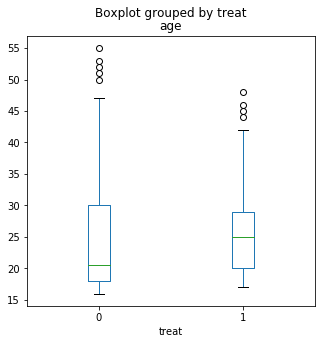

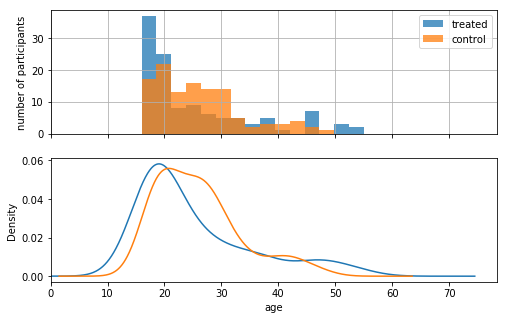


Control group
count    116.00
mean      25.25
std       10.15
min       16.00
25%       18.00
50%       20.50
75%       30.00
max       55.00
Name: age, dtype: float64

Treatment group
count    116.00
mean      25.90
std        7.39
min       17.00
25%       20.00
50%       25.00
75%       29.00
max       48.00
Name: age, dtype: float64

Mann-Whitney-U test:
p-value:  0.0088
test statistic:  5515.5




In [36]:
analyse_numeric(lalonde_data_balanced, 'age', detailed=False)

                                   educ


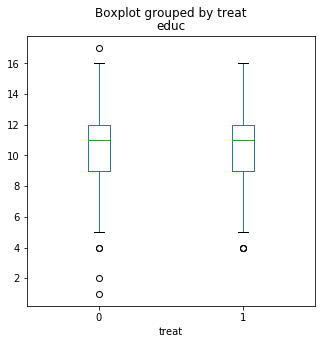

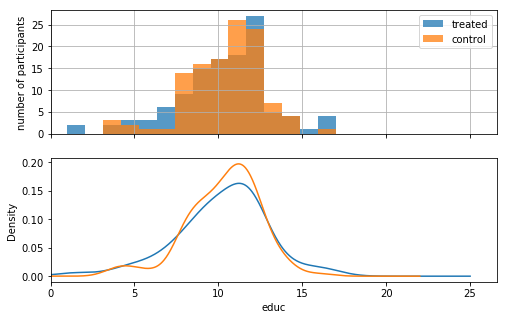


Control group
count    116.00
mean      10.22
std        2.73
min        1.00
25%        9.00
50%       11.00
75%       12.00
max       17.00
Name: educ, dtype: float64

Treatment group
count    116.00
mean      10.33
std        2.14
min        4.00
25%        9.00
50%       11.00
75%       12.00
max       16.00
Name: educ, dtype: float64

Mann-Whitney-U test:
p-value:  0.4484
test statistic:  6662.0




In [37]:
analyse_numeric(lalonde_data_balanced, 'educ', detailed=False)

                                   re74


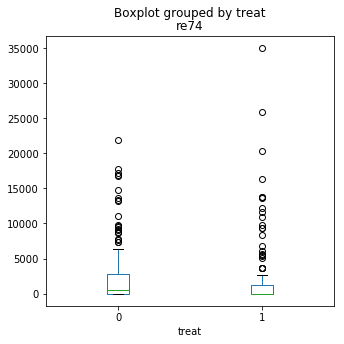

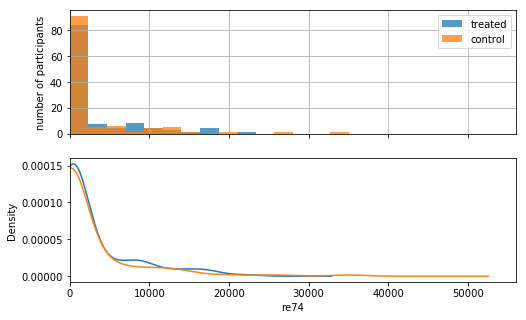


Control group
count      116.00
mean      2846.65
std       4818.60
min          0.00
25%          0.00
50%        515.29
75%       2760.12
max      21918.32
Name: re74, dtype: float64

Treatment group
count      116.00
mean      2351.18
std       5535.98
min          0.00
25%          0.00
50%          0.00
75%       1171.08
max      35040.07
Name: re74, dtype: float64

Mann-Whitney-U test:
p-value:  0.0001
test statistic:  5039.5




In [38]:
analyse_numeric(lalonde_data_balanced, 're74', detailed=False)

                                   re75


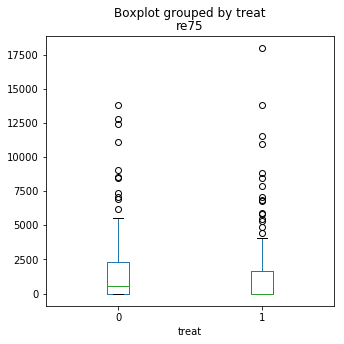

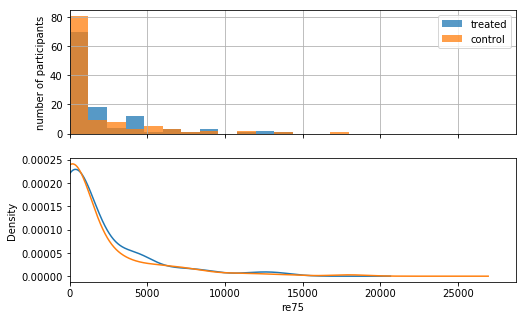


Control group
count      116.00
mean      1882.17
std       2943.71
min          0.00
25%          0.00
50%        555.00
75%       2302.80
max      13776.53
Name: re75, dtype: float64

Treatment group
count      116.00
mean      1587.20
std       3128.63
min          0.00
25%          0.00
50%          0.00
75%       1677.87
max      17976.15
Name: re75, dtype: float64

Mann-Whitney-U test:
p-value:  0.0082
test statistic:  5575.5




In [39]:
analyse_numeric(lalonde_data_balanced, 're75', detailed=False)

                                   married


married,0,1
treat,,
0,85,31
1,88,28


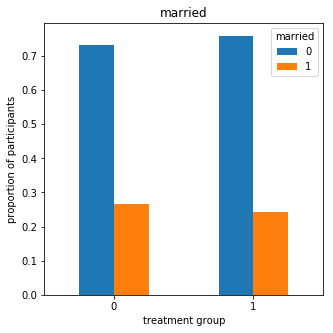


Chi-square test
p-value:  0.763
test statistic:  0.1




In [40]:
analyse_categoric(lalonde_data_balanced, 'married')

                                   nodegree


nodegree,0,1
treat,,
0,41,75
1,36,80


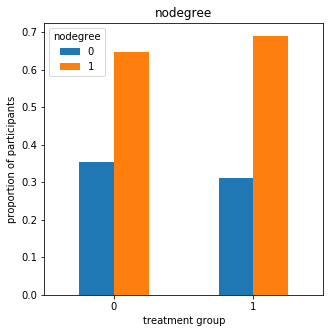


Chi-square test
p-value:  0.5771
test statistic:  0.3




In [41]:
analyse_categoric(lalonde_data_balanced, 'nodegree')

                                  race


,white,black,hispan
treat,,,
0,18,87,11
1,18,87,11


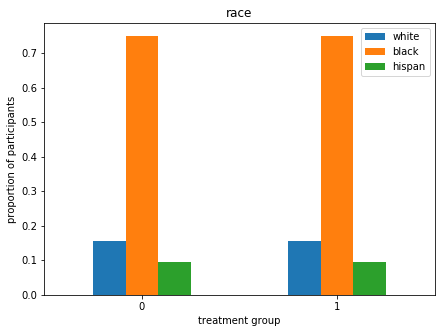



Chi-square test
p-value:  1.0
test statistic:  0.0


In [42]:
analyse_race(lalonde_data_balanced)

## 6. A less naive analysis

Remark that sensitivity analysis would be good!!

                                   re78


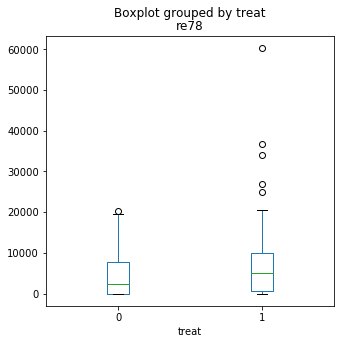

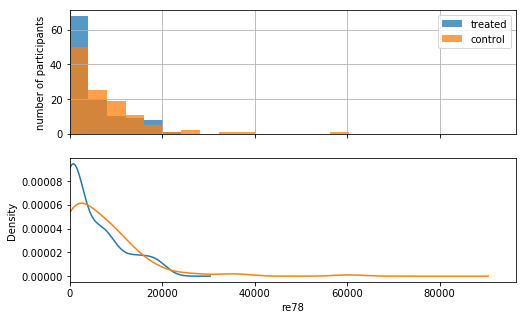


Control group
count      116.00
mean      4968.64
std       5855.64
min          0.00
25%          0.00
50%       2283.09
75%       7866.31
max      20243.38
Name: re78, dtype: float64

Treatment group
count      116.00
mean      7070.71
std       8607.70
min          0.00
25%        672.49
50%       5130.76
75%      10011.05
max      60307.93
Name: re78, dtype: float64

Mann-Whitney-U test:
p-value:  0.0249
test statistic:  5731.0




In [43]:
analyse_numeric(lalonde_data_balanced, 're78', detailed=False)

Compare the outcomes (re78) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5. What do you conclude about the effectiveness of the job training program